# GMM with IPOC data

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import sys
from sklearn import mixture
from sklearn import preprocessing
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import feature_extraction as fe
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Problems with merging IPOC and other (contininuous) data:
* IPOC triggers can be 10 sec apart
* continuous data has to be resampled to 1 sec
* calculating sliding windows after merging is impossible
* solution found, but too slow on laptop

In [12]:
client = mongo_client.CERNMongoClient()
start_date = '2016-07-16 00:00:00.000000'

# IPOC triggers are all at same time so query_resample can be used
joined = client.query_resample("^.*IPOC.AB1.*", None, "$gte", start_date)
# round timestamps to seconds for merging
index = joined.index.round("S")
joined["timestamps"] = index
joined = ad_pp.filter_extremes(joined)

continuous_pattern = "^MKI.(A|B).*B1:.*"
collections = [m.group(0) for l in client.get_all_collections() for m in [re.search(continuous_pattern, l)] if m]

for collection in collections:
    df = client.query_resample_collection(collection, "1s", "$gte", start_date)
    # Hold values in case of NaN, first forwards then backwards in case first value is NaN
    df = df.fillna(method='pad')
    df = df.fillna(method='backfill')
    df = ad_pp.filter_extremes(df)
    df["timestamps"] = df.index
    joined = pd.merge(joined, df, how='left')
    df.drop("timestamps", axis=1, inplace=True)
    SWM_T10 = fe.sliding_window_mean(df, "s", 600)
    SWM_T10["timestamps"] = SWM_T10.index
    joined = pd.merge(joined, SWM_T10, how='left')
    SWMD_T10 = fe.sliding_window_mean_diff(df, "s", 600)
    SWMD_T10["timestamps"] = SWM_T10.index
    joined = pd.merge(joined, SWMD_T10, how='left')
    SWS_T10 = fe.sliding_window_sum(df, "s", 600)
    SWS_T10["timestamps"] = SWS_T10.index
    joined = pd.merge(joined, SWS_T10, how='left')
    print "%s joined" % collection

# reset the index and drop it as column
joined.index = joined["timestamps"]
joined.drop("timestamps", axis=1, inplace=True)

Fetching data for pattern ^.*IPOC.AB1.*
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:E_KICK
Fetching data for MKI.UA23.IPOC.AB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.AB1:T_START_TH
Fetching data for MKI.UA23.IPOC.AB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.AB1:I_STRENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_DELAY
MKI.A5L2.B1:TEMP_MAGNET_UP joined
MKI.B5L2.B1:PRESSURE joined
MKI.B5L2.B1:TEMP_TUBE_DOWN joined
MKI.A5L2.B1:TEMP_TUBE_DOWN joined
MKI.B5L2.B1:TEMP_MAGNET_DOWN joined
MKI.B5L2.B1:TEMP_TUBE_UP joined
MKI.A5L2.B1:TEMP_TUBE_UP joined
MKI.B5L2.B1:TEMP_MAGNET_UP joined
MKI.A5L2.B1:PRESSURE joined
MKI.A5L2.B1:TEMP_MAGNET_DOWN joined


How does it work?
1. Query all IPOC data
2. Round timestamps to the second
3. Filter
4.Search all collection names matching regex for other, continuous data
5. Loop over collections
    1. Query the collection and fill missing
    2. Left join IPOC with new collection
    3. Create sliding windows and join with IPOC

In [13]:
display(joined.describe())

series  MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                 26278.000000              26278.000000   
mean                      3.782786               3792.964530   
std                      11.000298               2997.715228   
min                       0.000000                400.200000   
25%                       2.078900                450.000000   
50%                       2.081500               3565.920000   
75%                       3.477100               6499.440000   
max                     139.429700               7864.200000   

series  MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                   26278.000000                  26278.000000   
mean                        1.384051                     52.898070   
std                         1.529008                      6.681726   
min                      -124.124900                    -13.815000   
25%                         1.389600                     52.287000   
50%                         1.392900                     52.289000   
75%                         1.397600                     52.292000   
max                       124.476200                     62.789000   

series  MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                   26278.000000                  26278.000000   
mean                        0.654589                      4.567374   
std                         0.127375                      0.729779   
min                        -0.001800                      1.450600   
25%                         0.657300                      4.495900   
50%                         0.657800                      4.808600   
75%                         0.660500                      5.064900   
max                        13.626900                      5.193100   

series  MKI.UA23.IPOC.AB1:T_DELAY  MKI.A5L2.B1:TEMP_MAGNET_UP  \
count                26278.000000                26278.000000   
mean                    53.552659                   32.669842   
std                      6.725724                    7.196956   
min                    -13.814900                   21.000000   
25%                     52.945500                   26.500000   
50%                     52.947700                   31.600000   
75%                     52.951200                   39.300000   
max                     63.455000                   46.100000   

series  MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_s600  \
count                              26278.000000   
mean                                  32.678685   
std                                    7.202368   
min                                   21.000000   
25%                                   26.500000   
50%                                   31.600000   
75%                                   39.300000   
max                                   46.100000   

series  MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_s600  \
count                                   2.627800e+04   
mean                                   -8.843399e-03   
std                                     4.624393e-02   
min                                    -2.990000e-01   
25%                                    -1.193712e-12   
50%                                    -2.984279e-13   
75%                                     9.876544e-13   
max                                     2.995000e-01   

series                    ...                     \
count                     ...                      
mean                      ...                      
std                       ...                      
min                       ...                      
25%                       ...                      
50%                       ...                      
75%                       ...                      
max                       ...                      

series  MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_s600  \
count                                   2.627800e+04   
mean                         

In [22]:
joined = joined.drop(joined.index[3238]) # this row had a NaN value for MKI.B5L2.B1:PRESSURE 
dfs = ad_pp.scale_robust(joined)

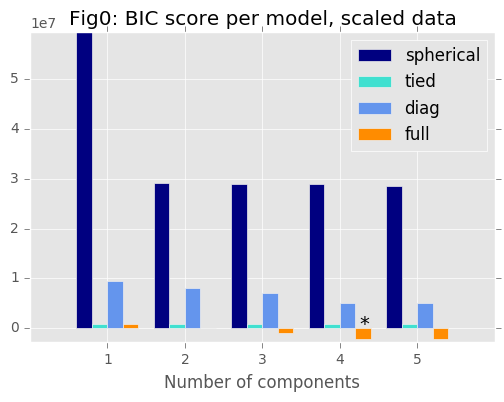

In [25]:
GMM.component_selection(dfs, 'Fig0: BIC score per model, scaled data', 5)

In [26]:
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [27]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.score_samples(dfs)
display("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]

'Log probs shape: 26275'

'Log probs mean: 41.0597875652'

'Log probs min: -210.545134321'

'Log probs max: 64.5168820855'

'1pct percentile: -10'

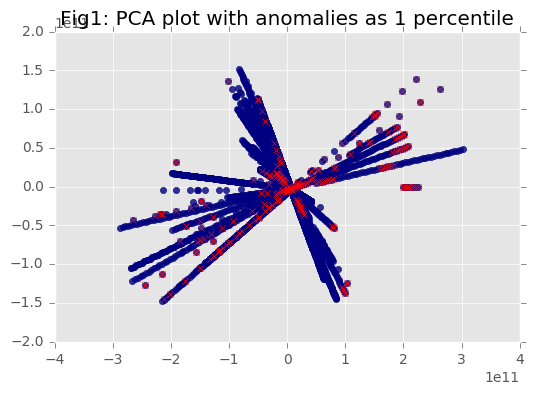

In [28]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(dfs, pca)
PCA.plot_anomalies(pca_data, idx[0], "Fig1: PCA plot with anomalies as 1 percentile")

In [55]:
df_elogbook = client.query_resample("MKI.ELOGBOOK", None, "$gte", '2016-04-00 00:00:00.000000')
# marker column is to plot it together with other data
df_elogbook['marker'] = 0
df_elogbook = df_elogbook.ix[start_date:]

Fetching data for pattern MKI.ELOGBOOK
Fetching data for MKI.ELOGBOOK


I can't query the MKI.ELOGBOOK from startdate, maybe problem with the index?

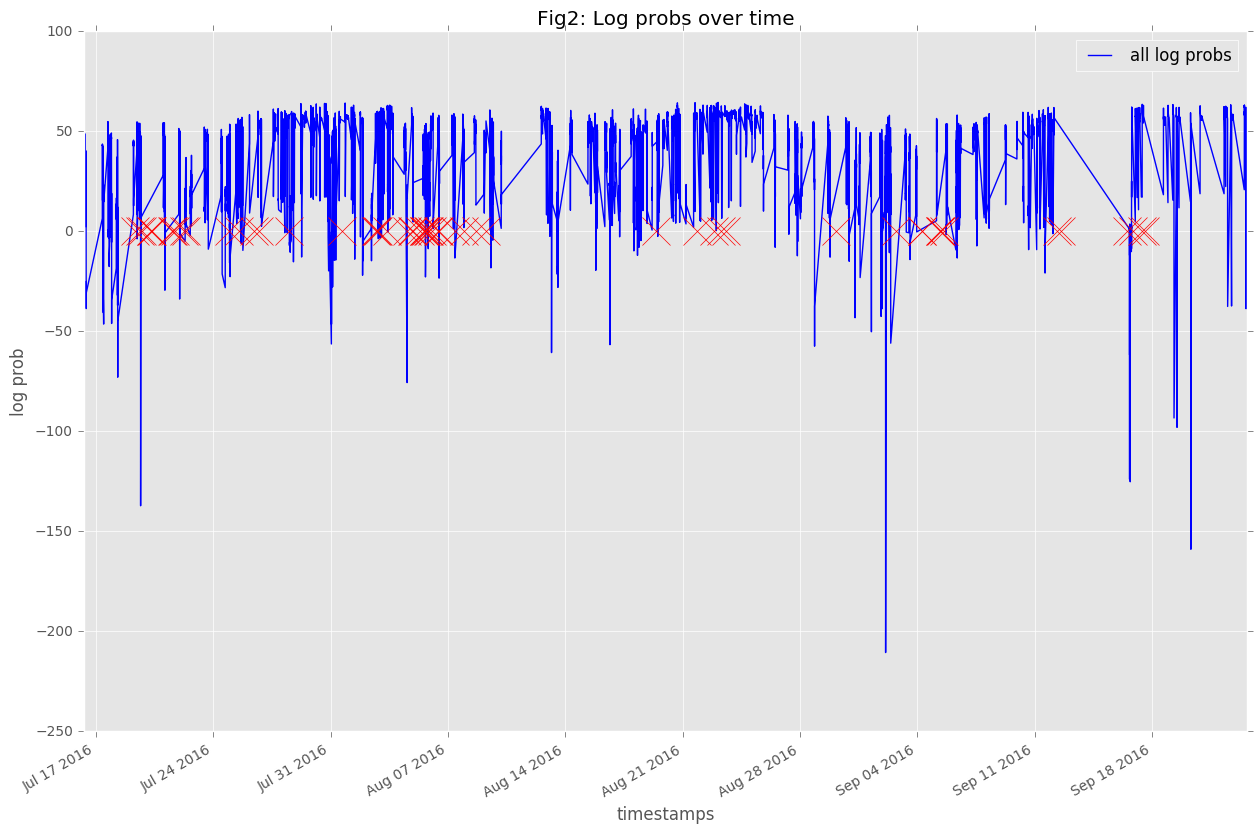

In [56]:
log_probs_df = pd.DataFrame(data=log_probs, index=dfs.index)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df.plot(ax=axes, color='b')
df_elogbook.plot(ax=axes, y='marker', linestyle='none', marker='x', markersize=20, color='red')
labels = ["all log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig2: Log probs over time")

In [57]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

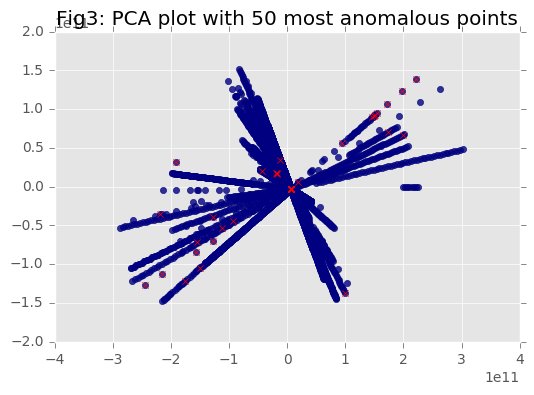

In [58]:
PCA.plot_anomalies(pca_data, top50, "Fig3: PCA plot with 50 most anomalous points")

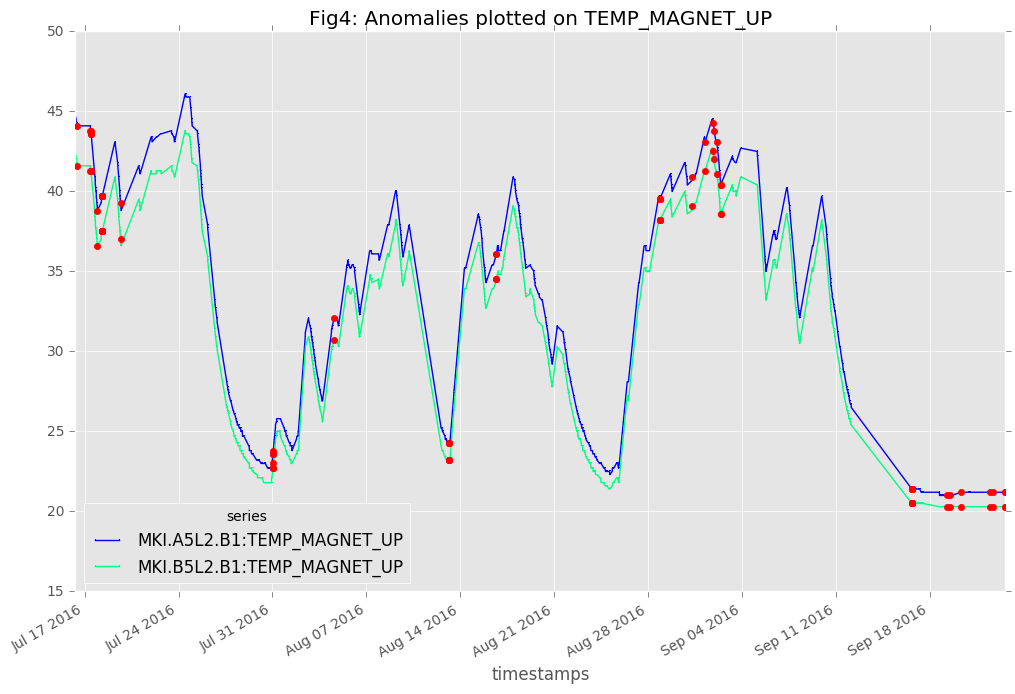

In [59]:
results.plot_anomalies_timeseries(joined, top50, "TEMP_MAGNET_UP", "Fig4: Anomalies plotted on TEMP_MAGNET_UP")

! Interpolation happens in the figure ! Not every point in time is in the dataframe, only IPOC trigger times